# MNIST
In this notebook we will classify the images from MNIST hand-written database.
The process goes like:
<ol>
    <li>Data Loading and preprocessing
    <li>Define model
    <li>Train the model
    <li>Model evaluation and predictions

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Data Loading and preprocessing

In [18]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers=0
batch_size=20
valid_size=0.2

transform=transforms.ToTensor()

train_data=datasets.MNIST(root='data',train=True,download=True,transform=transform)
test_data=datasets.MNIST(root='data',train=False,download=True,transform=transform)

num_train=len(train_data)
indices=list(range(num_train))
np.random.shuffle(indices)
split=int(np.floor(valid_size*num_train))
train_index,valid_index=indices[split:],indices[:split]

train_sampler=SubsetRandomSampler(train_index)
valid_sampler=SubsetRandomSampler(valid_index)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


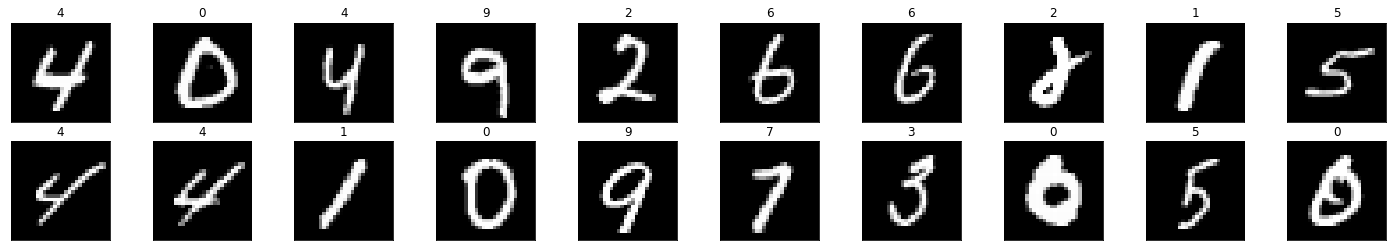

In [19]:
one_batch = iter(train_loader)
images, labels = one_batch.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))


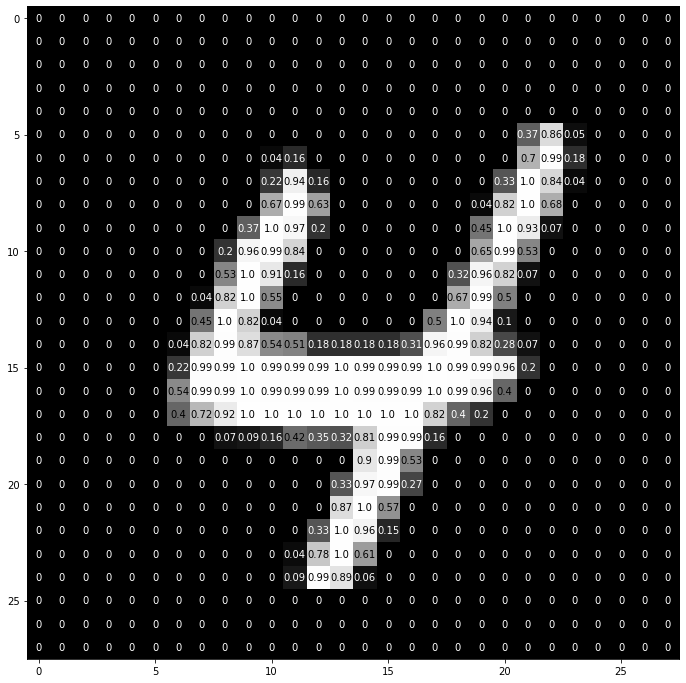

In [20]:
img = np.squeeze(images[0])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Defining model

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1=nn.Linear(28*28,512)
        self.fc2=nn.Linear(512,512)
        self.fc3=nn.Linear(512,10)
        
        self.dropout=nn.Dropout(0.2)
    
    def forward(self,x):
        x=x.view(-1,28*28)
        x = F.relu(self.fc1(x))        
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model=Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Training the model

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [23]:
epochs=40

valid_loss_min=np.inf;
train_losses=[]
validation_losses=[]
for epoch in range(epochs):
    train_loss=0
    valid_loss=0
    
    model.train()
    for image,label in train_loader:
        optimizer.zero_grad()
        output=model(image)
        loss=criterion(output,label)
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
    
    model.eval()
    for image,label in valid_loader:
        output=model(image)
        loss=criterion(output,label)
        valid_loss+=loss.item()
    
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    print("Epoch: {}\tTraining Loss: {}\tValidation Loss: {}".format(epoch,train_loss,valid_loss))
    
    if valid_loss <= valid_loss_min:
        print("Saving model")
        torch.save(model.state_dict(), 'mnist_model.pt')
        valid_loss_min = valid_loss
    

Epoch: 0	Training Loss: 2288.892566859722	Validation Loss: 225.35312056541443
Saving model
Epoch: 1	Training Loss: 853.3482397720218	Validation Loss: 170.96802937239408
Saving model
Epoch: 2	Training Loss: 678.0941873034462	Validation Loss: 141.0676498748362
Saving model
Epoch: 3	Training Loss: 562.9008548203856	Validation Loss: 118.64821698050946
Saving model
Epoch: 4	Training Loss: 474.74933385197073	Validation Loss: 103.13580006733537
Saving model
Epoch: 5	Training Loss: 413.55358759034425	Validation Loss: 93.32473969645798
Saving model
Epoch: 6	Training Loss: 361.40118133928627	Validation Loss: 82.8665012549609
Saving model
Epoch: 7	Training Loss: 325.5296081462875	Validation Loss: 80.54530045576394
Saving model
Epoch: 8	Training Loss: 296.66428362205625	Validation Loss: 68.95749388821423
Saving model
Epoch: 9	Training Loss: 267.29870697134174	Validation Loss: 64.52231198782101
Saving model
Epoch: 10	Training Loss: 242.09268784243613	Validation Loss: 61.033465198474005
Saving model

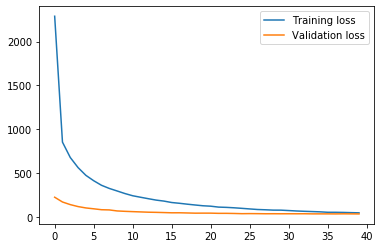

In [24]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend()

## Loading saved Model

In [25]:
model.load_state_dict(torch.load('mnist_model.pt'))

<All keys matched successfully>

## Evaluating Model

In [26]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of {}: {}%% ({}/{})'.format(
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): {}%% ({}/{})'.format(
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.0028698526178893642

Test Accuracy of 0: 99.18367346938776%% (972.0/980.0)
Test Accuracy of 1: 99.29515418502203%% (1127.0/1135.0)
Test Accuracy of 2: 97.86821705426357%% (1010.0/1032.0)
Test Accuracy of 3: 98.61386138613861%% (996.0/1010.0)
Test Accuracy of 4: 98.16700610997964%% (964.0/982.0)
Test Accuracy of 5: 98.31838565022422%% (877.0/892.0)
Test Accuracy of 6: 98.43423799582463%% (943.0/958.0)
Test Accuracy of 7: 97.47081712062257%% (1002.0/1028.0)
Test Accuracy of 8: 97.74127310061601%% (952.0/974.0)
Test Accuracy of 9: 97.9187314172448%% (988.0/1009.0)

Test Accuracy (Overall): 98.31%% (9831.0/10000.0)


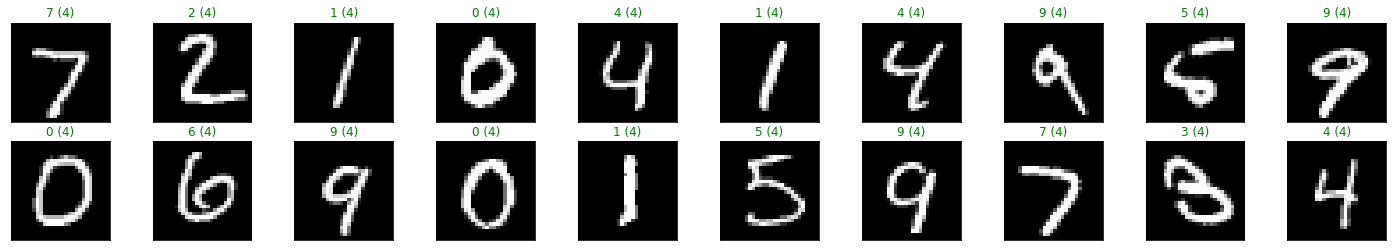

In [29]:
batch=iter(test_loader)
images,labels=batch.next()

output=model(images)
_,preds=torch.max(output,1)
images=images.numpy()

fig=plt.figure(figsize=(25,4))
for index in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, index+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[index]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[index].item()), str(labels[idx].item())),color=("green" if preds[index]==labels[index] else "red"))

## Making predictions

In [31]:
def prediction(index):
    batch=iter(test_loader)
    images,labels=batch.next()
    output=model(images[index])
    _,pred=torch.max(output,1)
    images=images.numpy()
    fig=plt.figure(figsize=(25,4))
    ax = fig.add_subplot(2,10, index+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[index]), cmap='gray')
    ax.set_title("Predicted Value: {}".format(str(pred.item())))

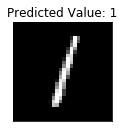

In [33]:
prediction(2)